In [1]:
# importing the pertinent libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.stattools import adfuller # stationarity check

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # determining the optimal values of parameters

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # model assessment

import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Dataset

In [2]:
us_pce=pd.read_excel('us_pce_sarima.xlsx')
us_pce.head()

,Date,PCE
0,1980-01-01,1697.3
1,1980-02-01,1701.4
2,1980-03-01,1708.2
3,1980-04-01,1695.2
4,1980-05-01,1700.1


# 1. Preceding with basic visualisation

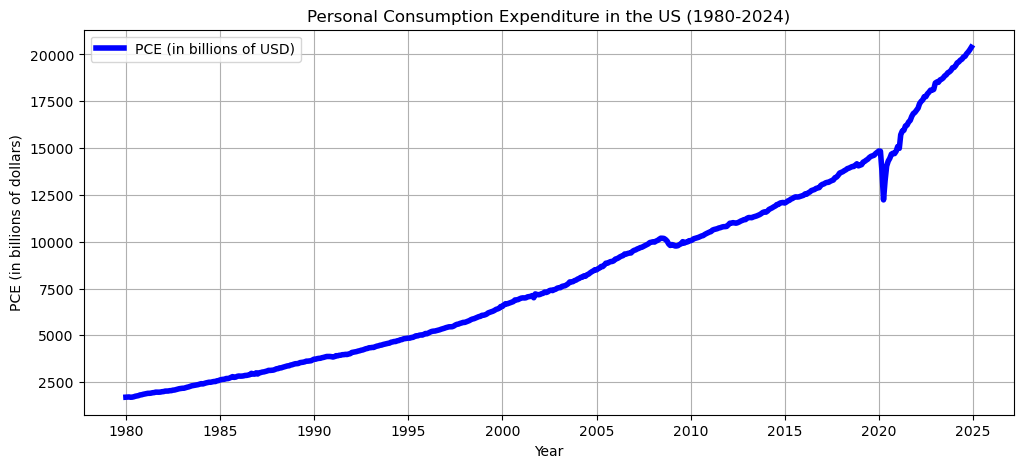

In [5]:
plt.figure(figsize=(12,5))
plt.plot(us_pce['Date'],us_pce['PCE'],color='blue',linewidth=4,label='PCE (in billions of USD)')

plt.title('Personal Consumption Expenditure in the US (1980-2024)')
plt.xlabel('Year')
plt.ylabel('PCE (in billions of dollars)')
plt.legend()
plt.grid()
plt.show()

# as observed in the plot below, there is a clear upward trend in PCE over time
# this makes the dataset suitable for forecasting

# 2. Pre-processing

In [6]:
us_pce.isnull().sum()

# no null values

Date    0
PCE     0
dtype: int64

In [7]:
us_pce.info()

# date column identified as datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    540 non-null    datetime64[ns]
 1   PCE     540 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [8]:
# checking if data is stationary with the ADF test

result=adfuller(us_pce['PCE'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary. No differencing needed.")
    d=0
else:
    print("The series is NOT stationary. Differencing needed.")
    d=1  # Assume first order differencing; we'll verify later.

ADF Statistic: 3.782311298935647
p-value: 1.0
The series is NOT stationary. Differencing needed.


In [9]:
us_pce['pce_diff']=us_pce['PCE'].diff().dropna()

# ADF Test on Differenced Data
result_diff = adfuller(us_pce['pce_diff'].dropna())
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value: {result_diff[1]}")

if result_diff[1] < 0.05:
    print("The differenced series is now stationary.")
    d = 1
else:
    print("Further differencing might be required.")
    d = 2  # Rare but possible.

ADF Statistic (after differencing): -4.9282169509673786
p-value: 3.0722100609699054e-05
The differenced series is now stationary.


# 3. Splitting the dataset -- train and test

In [10]:
# Train-test split
train_size=int(len(us_pce) * 0.8)  # 80% train, 20% test
train, test=us_pce.iloc[:train_size], us_pce.iloc[train_size:]

# 4. Building the SARIMA model

In [19]:
# Instead of manually choosing (p, d, q, P, D, Q), we can let pmdarima do the work.

# Auto-ARIMA to find best (p,d,q) and (P,D,Q)
stepwise_fit=auto_arima(train['PCE'], 
                        seasonal=True, # Indicates we need a SARIMA model
                        m=12, # 12-month seasonality
                        d=1, # as we confirmed with the ADF test, only first-order differencing required for a stationary dataset
                        D=2, # Seasonal differencing order
                        trace=True,
                        suppress_warnings=True)

# Print the best SARIMA model order
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,2,1)[12]             : AIC=inf, Time=38.56 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=4622.206, Time=0.14 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=4434.617, Time=1.40 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=4622.905, Time=0.15 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=4307.948, Time=8.90 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=101.60 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=14.33 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=4307.836, Time=10.69 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=4433.073, Time=2.42 sec
 ARIMA(0,1,0)(2,2,1)[12]             : AIC=inf, Time=71.68 sec
 ARIMA(0,1,0)(1,2,1)[12]             : AIC=inf, Time=8.21 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=4308.395, Time=11.97 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=inf, Time=74.17 sec
 ARIMA(0,1,0)(2,2,0)[12] intercept   : AIC=430

In [20]:
# fitting the best SARIMA model on training data
sarima_model=SARIMAX(train['PCE'], 
                     order=stepwise_fit.order, 
                     seasonal_order=stepwise_fit.seasonal_order,
                     enforce_stationarity=False, 
                     enforce_invertibility=False)

sarima_result=sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                PCE   No. Observations:                  432
Model:             SARIMAX(0, 1, 0)x(2, 2, 0, 12)   Log Likelihood               -2027.782
Date:                            Tue, 13 May 2025   AIC                           4061.564
Time:                                    09:59:11   BIC                           4073.408
Sample:                                         0   HQIC                          4066.263
                                            - 432                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9535      0.029    -32.547      0.000      -1.011      -0.896
ar.S.L24      -0.5385      0.035   

# 5. Residual analysis

In [23]:
# 1. autocorrelation check with Ljung-Box (level of significance = 0.05)
        # H0: no autocorrelation
        # with p-value > 0.05, we do not reject H0, thereby conlcuding that autocorrelation is not present
# 2. heteroscedasticity check (level of significance = 0.05)
        # H0: residuals exhibit homoscedasticity
        # with p-value < 0.05, we do not accept H0, thereby conlcluding that there is heteroscedasticity in the residuals
# 3. normality check with Jarque-Bera (level of significance = 0.05)
        # H0: residuals are normality distributed (skew=0, kurtosis=3)
        # with p-value < 0.05, we do not accept H0, thereby concluding that the residuals are not normally distributed

# all apparent with the graphs below

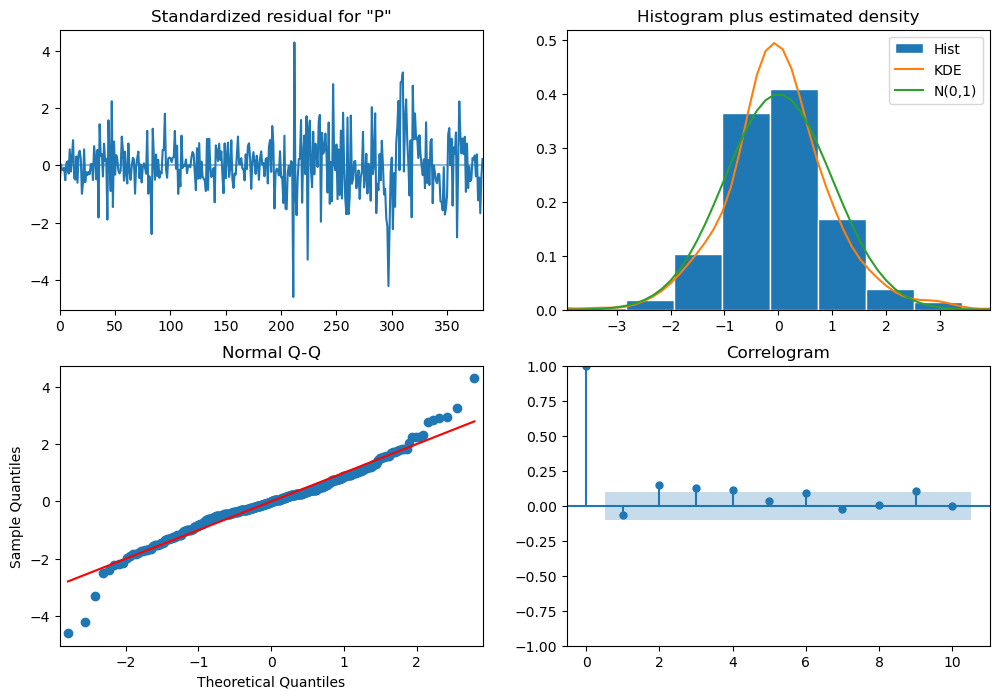

In [82]:
sarima_result.plot_diagnostics(figsize=(12,8))
plt.show()

# 6. Forecasting

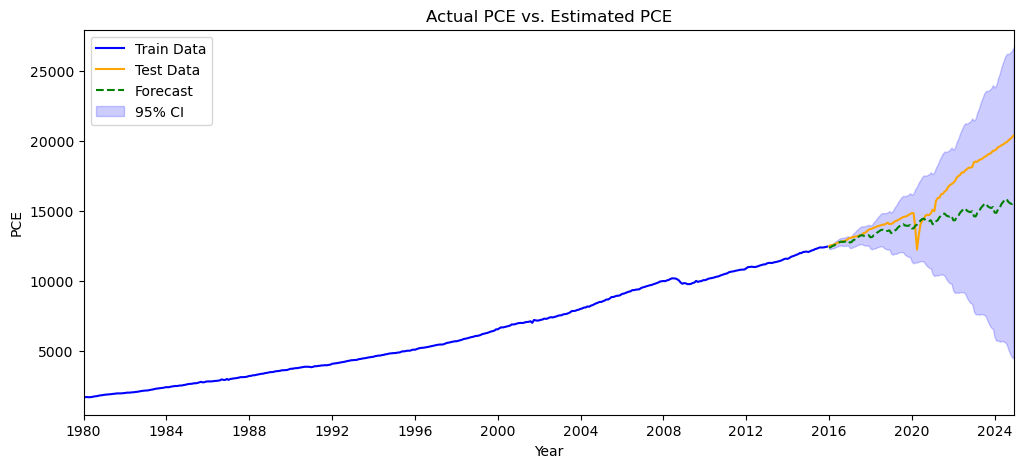

In [69]:
# for the test period
forecast=sarima_result.get_forecast(steps=len(test))
forecast_index=test['Date']
forecast_values=forecast.predicted_mean
conf_int=forecast.conf_int()

plt.figure(figsize=(12,5))

plt.plot(train['Date'], train['PCE'], label="Train Data", color='blue')
plt.plot(test['Date'], test['PCE'], label="Test Data", color='orange')
plt.plot(forecast_index, forecast_values, label="Forecast", color='green', linestyle='--')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2, label="95% CI")


# Formatting and labels
plt.xlabel("Year")
plt.ylabel("PCE")
plt.title("Actual PCE vs. Estimated PCE")
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))

# Set x-axis limits using Date column instead of index
plt.xlim(train['Date'].min(), test['Date'].max())

plt.show()

C:\Users\Neha Rana\AppData\Local\Temp\ipykernel_9132\2800589636.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extended_forecast_index=pd.date_range(start=test['Date'].iloc[-1], periods=future_steps, freq='M')


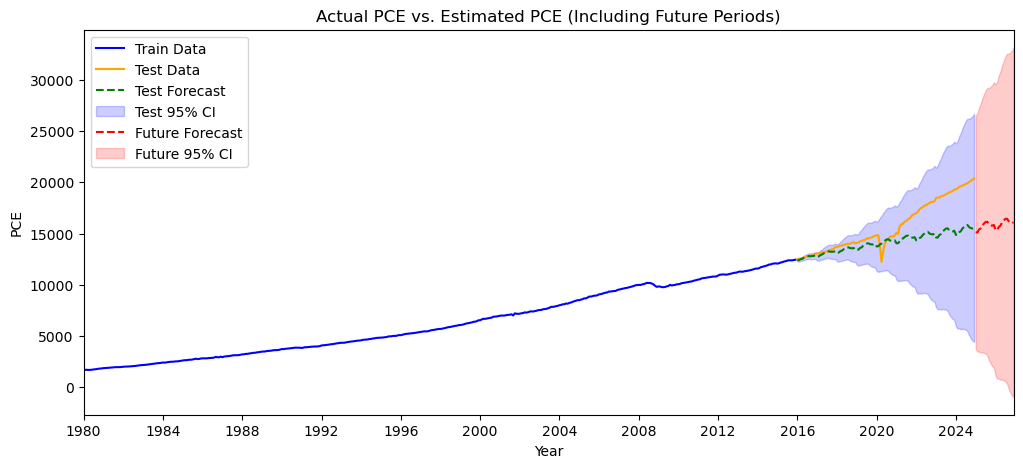

In [67]:
# forecasting for the next 2 years, i.e., next 24 months
future_steps=2*12

# Forecast beyond test period
extended_forecast=sarima_result.get_forecast(steps=len(test) + future_steps)
extended_forecast_index=pd.date_range(start=test['Date'].iloc[-1], periods=future_steps, freq='M')
extended_forecast_values=extended_forecast.predicted_mean[-future_steps:]
extended_conf_int=extended_forecast.conf_int().iloc[-future_steps:]

plt.figure(figsize=(12,5))

# Plot historical data
plt.plot(train['Date'], train['PCE'], label="Train Data", color='blue')
plt.plot(test['Date'], test['PCE'], label="Test Data", color='orange')

# Plot test period forecast
plt.plot(forecast_index, forecast_values, label="Test Forecast", color='green', linestyle='--')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2, label="Test 95% CI")

# Plot extended forecast
plt.plot(extended_forecast_index, extended_forecast_values, label="Future Forecast", color='red', linestyle='--')
plt.fill_between(extended_forecast_index, extended_conf_int.iloc[:, 0], extended_conf_int.iloc[:, 1], color='red', alpha=0.2, label="Future 95% CI")

# Formatting and labels
plt.xlabel("Year")
plt.ylabel("PCE")
plt.title("Actual PCE vs. Estimated PCE (Including Future Periods)")
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))

# Extend x-axis limits to include future forecast
plt.xlim(train['Date'].min(), extended_forecast_index.max())

plt.show()

# 7. Assessing model

In [71]:
mae=mean_absolute_error(test['PCE'],forecast_values)
mse=mean_squared_error(test['PCE'],forecast_values)
r2=r2_score(test['PCE'],forecast_values)

print('Mean Absolute Error:',mae)
print('Mean Squared Error:',mse)
print('R-Squared:',r2)

Mean Absolute Error: 1613.1661508791858
Mean Squared Error: 5036798.95354049
R-Squared: 0.1573644450144317


In [25]:
# Clearly, the model's accuracy is quite pooor -- r-squared of 0.157!

# Need to revise the model
# It seems like the COVID-19 pandemic, an exogenous shock, has interfered with this model.

# To address this, the data will not begin from the month of 1st January 2022, marking a recovery from the pandemic.
# This revision in the train data is able to capture the recent economic shifts in:
    # 1. consumer behaviour,
    # 2. supply chain disruption, and
    # 3. policy (fiscal + monetary)

# Thus, instead of altering the fundamental formation of this model, we alter only the time period we are training our model on.

# Revised model

In [5]:
us_pce.loc[504]

Date    2022-01-01 00:00:00
PCE                 17017.8
Name: 504, dtype: object

In [9]:
us_pce_revised=us_pce.loc[504:539]
#us_pce_revised=us_pce_revised.drop(['pce_diff'],axis=1)
us_pce_revised.head()

,Date,PCE
504,2022-01-01,17017.8
505,2022-02-01,17136.1
506,2022-03-01,17371.4
507,2022-04-01,17493.8
508,2022-05-01,17569.9


# 1. Preceding with visualisation

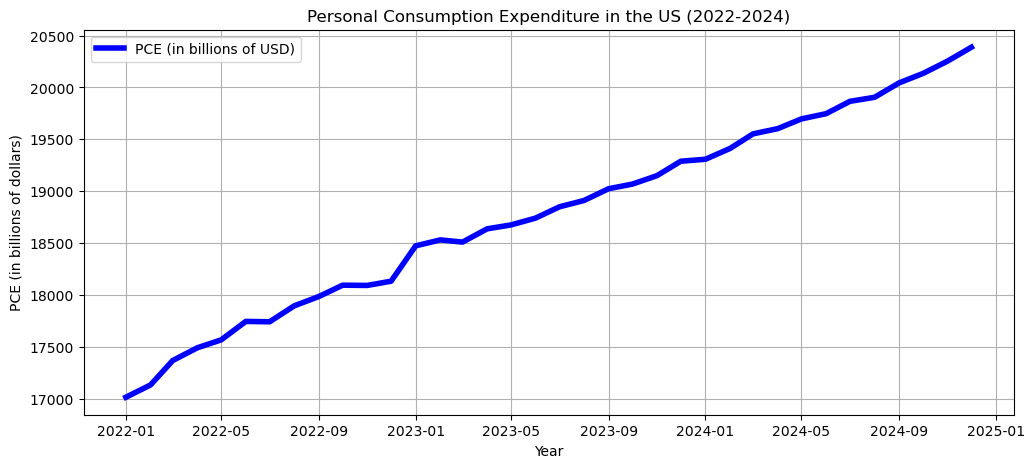

In [38]:
plt.figure(figsize=(12,5))
plt.plot(us_pce_revised['Date'],us_pce_revised['PCE'],color='blue',linewidth=4,label='PCE (in billions of USD)')

plt.title('Personal Consumption Expenditure in the US (2022-2024)')
plt.xlabel('Year')
plt.ylabel('PCE (in billions of dollars)')
plt.legend()
plt.grid()
plt.show()

# 2. Pre-processing

In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
result = adfuller(us_pce_revised['PCE'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary. No differencing needed.")
    d = 0
else:
    print("The series is NOT stationary. Differencing needed.")
    d = 1  # Assume first order differencing; we'll verify later.

ADF Statistic: -0.2755929459456354
p-value: 0.9288906740784303
The series is NOT stationary. Differencing needed.


In [13]:
us_pce['pce_diff'] = us_pce_revised['PCE'].diff().dropna()

# ADF Test on Differenced Data
result_diff = adfuller(us_pce['pce_diff'].dropna())
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value: {result_diff[1]}")

if result_diff[1] < 0.05:
    print("The differenced series is now stationary.")
    d = 1
else:
    print("Further differencing might be required.")
    d = 2  # Rare but possible.

ADF Statistic (after differencing): -6.497403976613483
p-value: 1.1848512543589921e-08
The differenced series is now stationary.


# 3. Splitting the dataset -- train and test

In [17]:
# Train-test split
train_size_1=int(len(us_pce_revised) * 0.8)  # 80% train, 20% test
train_1, test_1=us_pce_revised.iloc[:train_size_1], us_pce_revised.iloc[train_size_1:]

# 4. Building the revised SARIMA model

In [21]:
stepwise_fit=auto_arima(train_1['PCE'], 
                        seasonal=True, 
                        m=12, 
                        d=1, 
                        D=1,
                        trace=True,
                        suppress_warnings=True)

print(stepwise_fit.summary())

sarima_model_1=SARIMAX(train_1['PCE'], 
                       order=stepwise_fit.order, 
                       seasonal_order=stepwise_fit.seasonal_order,
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_result_1=sarima_model_1.fit()
print(sarima_result_1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=7.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=191.190, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=194.335, Time=1.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=194.341, Time=4.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=192.495, Time=1.93 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=192.480, Time=0.41 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=194.455, Time=0.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=192.919, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=192.937, Time=0.45 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=194.919, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=192.240, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 17.616 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observati

# 5. Residual Analysis

In [ ]:
# 1. autocorrelation check with Ljung-Box (level of significance = 0.05)
        # H0: no autocorrelation
        # with p-value > 0.05, we do not reject H0, thereby concluding that autocorrelation is not present
# 2. heteroscedasticity check (level of significance = 0.05)
        # H0: residuals exhibit homoscedasticity
        # with p-value > 0.05, we do not reject H0, thereby concluding on the homoscedasticity of the residuals
# 3. normality check with Jarque-Bera (level of significance = 0.05)
        # H0: residuals are normality distributed (skew=0, kurtosis=3)
        # with p-value > 0.05, we do not reject H0, thereby concluding that the residuals are normally distributed

# all apparent with the graphs below

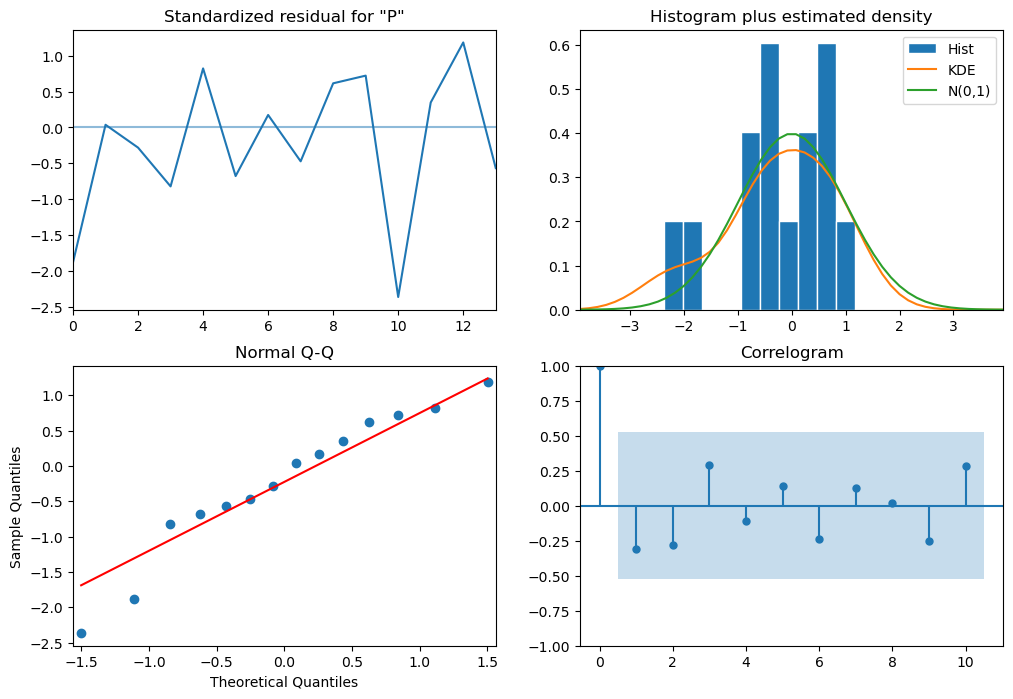

In [25]:
sarima_result_1.plot_diagnostics(figsize=(12,8))
plt.show()

# 6. Forecasting

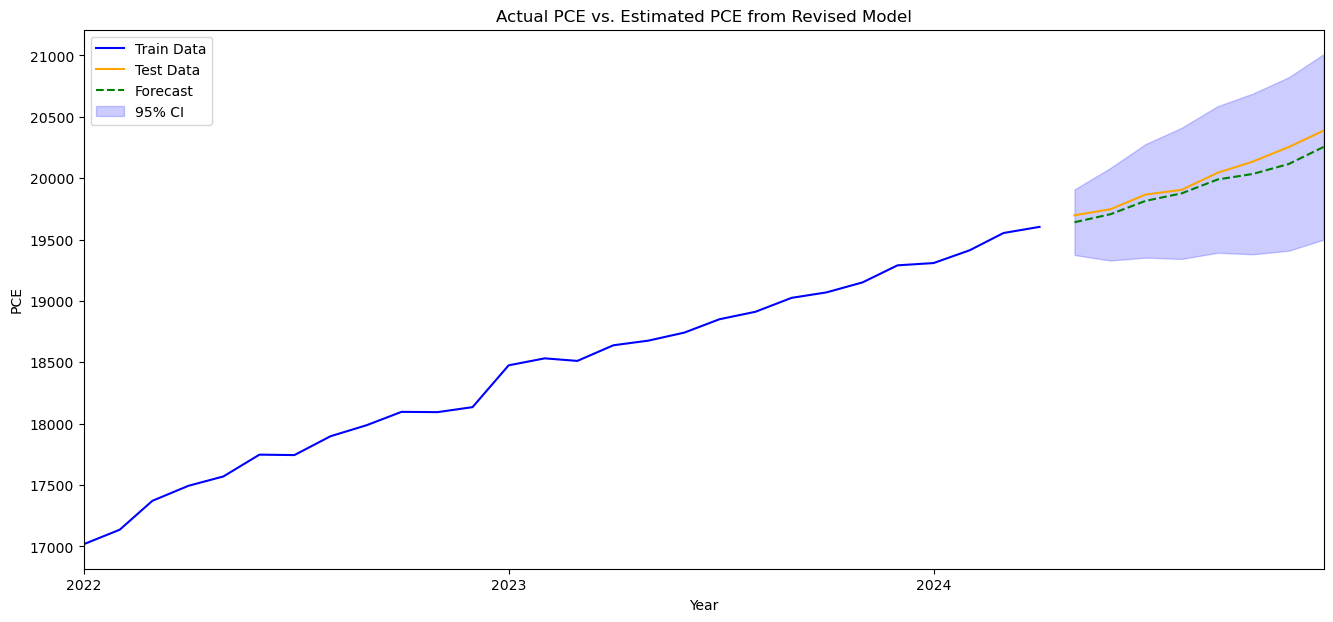

In [27]:
# Forecast for test period
forecast_1=sarima_result_1.get_forecast(steps=len(test_1))
forecast_index_1=test_1['Date']
forecast_values_1=forecast_1.predicted_mean
conf_int_1=forecast_1.conf_int()

plt.figure(figsize=(16,7))

plt.plot(train_1['Date'], train_1['PCE'], label="Train Data", color='blue')
plt.plot(test_1['Date'], test_1['PCE'], label="Test Data", color='orange')
plt.plot(forecast_index_1, forecast_values_1, label="Forecast", color='green', linestyle='--')
plt.fill_between(forecast_index_1, conf_int_1.iloc[:, 0], conf_int_1.iloc[:, 1], color='blue', alpha=0.2, label="95% CI")


# Formatting and labels
plt.xlabel("Year")
plt.ylabel("PCE")
plt.title("Actual PCE vs. Estimated PCE from Revised Model")
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show ticks every 5 years

# Set x-axis limits using Date column instead of index
plt.xlim(train_1['Date'].min(), test_1['Date'].max())

plt.show()

C:\Users\Neha Rana\AppData\Local\Temp\ipykernel_19332\3186640725.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extended_forecast_index_1=pd.date_range(start=test_1['Date'].iloc[-1], periods=future_steps_1, freq='M')


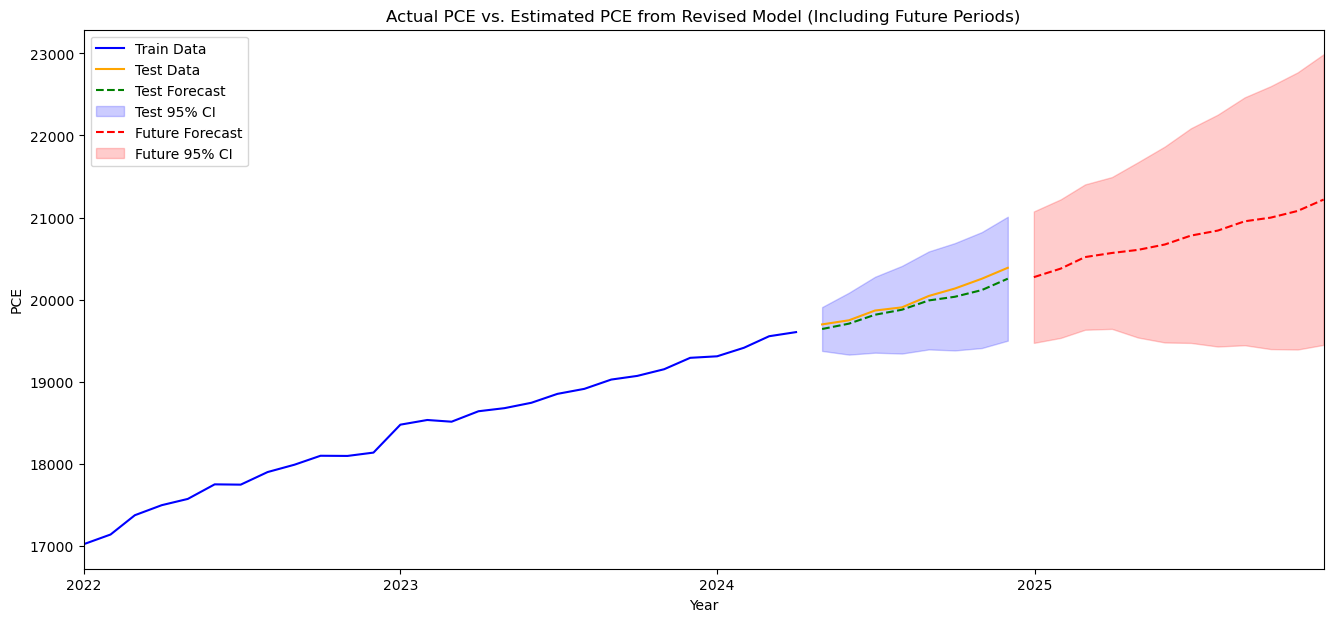

In [35]:
# forecasting for the next 1 year
future_steps_1=1*12

# Forecast beyond test period
extended_forecast_1=sarima_result_1.get_forecast(steps=len(test_1) + future_steps_1)
extended_forecast_index_1=pd.date_range(start=test_1['Date'].iloc[-1], periods=future_steps_1, freq='M')
extended_forecast_values_1=extended_forecast_1.predicted_mean[-future_steps_1:]
extended_conf_int_1=extended_forecast_1.conf_int().iloc[-future_steps_1:]

plt.figure(figsize=(16,7))

# Plot historical data
plt.plot(train_1['Date'], train_1['PCE'], label="Train Data", color='blue')
plt.plot(test_1['Date'], test_1['PCE'], label="Test Data", color='orange')

# Plot test period forecast
plt.plot(forecast_index_1, forecast_values_1, label="Test Forecast", color='green', linestyle='--')
plt.fill_between(forecast_index_1, conf_int_1.iloc[:, 0], conf_int_1.iloc[:, 1], color='blue', alpha=0.2, label="Test 95% CI")

# Plot extended forecast
plt.plot(extended_forecast_index_1, extended_forecast_values_1, label="Future Forecast", color='red', linestyle='--')
plt.fill_between(extended_forecast_index_1, extended_conf_int_1.iloc[:, 0], extended_conf_int_1.iloc[:, 1], color='red', alpha=0.2, label="Future 95% CI")

# Formatting and labels
plt.xlabel("Year")
plt.ylabel("PCE")
plt.title("Actual PCE vs. Estimated PCE from Revised Model (Including Future Periods)")
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(1))  # Show ticks every 5 years

# Extend x-axis limits to include future forecast
plt.xlim(train_1['Date'].min(), extended_forecast_index_1.max())

plt.show()

# 7. Assessment

In [49]:
mae_1=mean_absolute_error(test_1['PCE'],forecast_values_1)
mse_1=mean_squared_error(test_1['PCE'],forecast_values_1)
r2_1=r2_score(test_1['PCE'],forecast_values_1)

print('Mean Absolute Error:',mae_1)
print('Mean Squared Error:',mse_1)
print('R-Squared:',r2_1)

Mean Absolute Error: 75.35000000000082
Mean Squared Error: 7249.977500000092
R-Squared: 0.8607108051139462


In [53]:
# R-squared has significantly enhanced from 0.157 to 0.861!